In [1]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.datasets import MultiTemporalCropClassification
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [ ]:
# If you dont have the dataset yet, download it at https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification
# from huggingface_hub import snapshot_download

# repo_id = <repo_id>
# local_path = snapshot_download(repo_id=repo_id)

## MultiTemporalCrop Example

In [2]:
DATASET_PATH = os.path.join('dataset', 'hls_cdl_reclassed')

In [3]:
# those are the recommended transforms for this task
transforms = [
    terratorch.datasets.transforms.FlattenTemporalIntoChannels(),
    albumentations.Flip(),
    albumentations.pytorch.transforms.ToTensorV2(),
    terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
]

In [4]:
# this datamodule allows access to the dataset in its various splits.
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    expand_temporal_dimension=True,
)

In [5]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [6]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3083

In [7]:
# checking datasets available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [8]:
# checking datasets classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

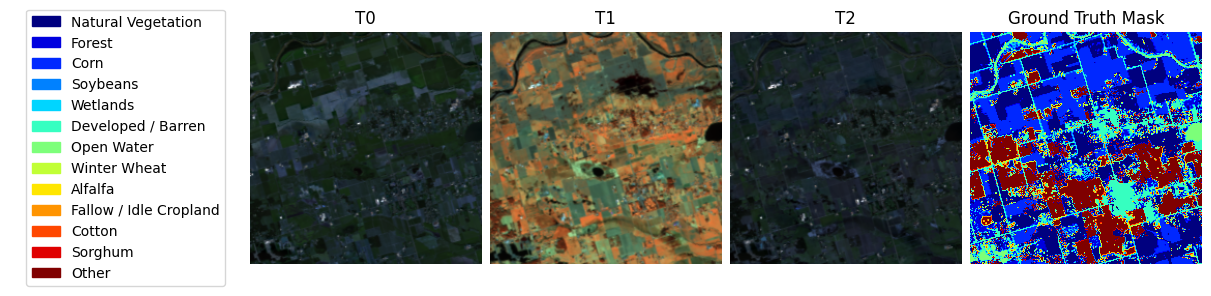

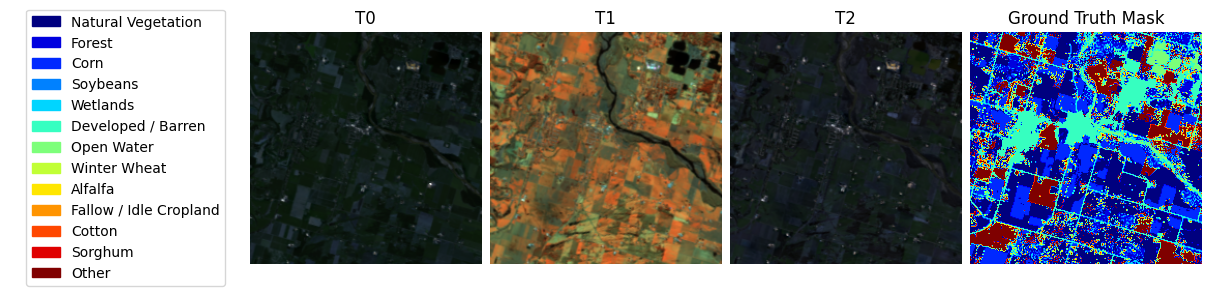

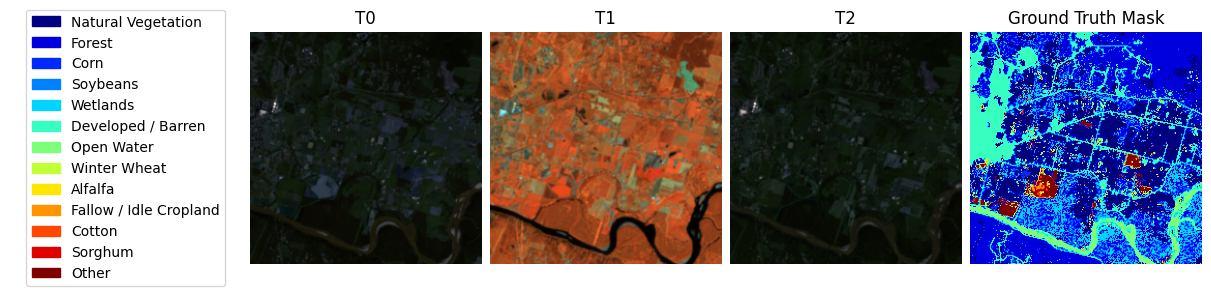

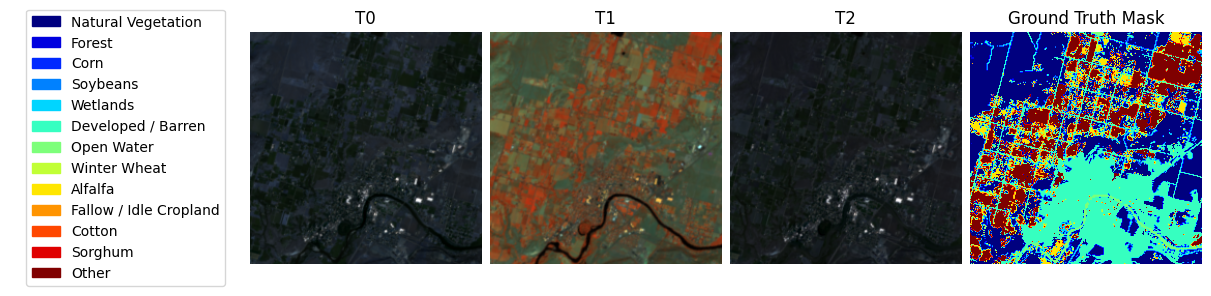

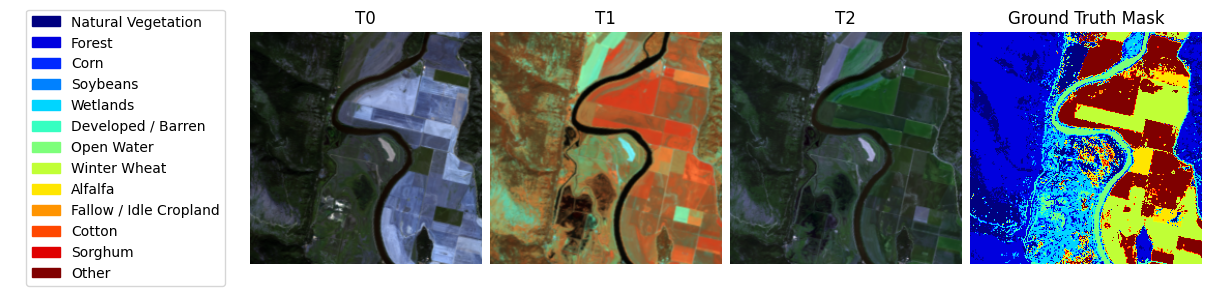

In [9]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [10]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

771

In [11]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

771

In [12]:
# Logger
logger = TensorBoardLogger(
    save_dir="output",
    name="tutorial"
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",
    mode="max",
    dirpath="checkpoints",
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    num_nodes=1,
    logger = logger,
    max_epochs=30,
    check_val_every_n_epoch=2,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    default_root_dir="root_dir",
)

# DataModule
data_module = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    reduce_zero_label=True,
    expand_temporal_dimension=True,
    use_metadata=True, # Multicropclassification dataset has metadata for location and time
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300_tl", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "backbone_features_only": True,
        "backbone_coords_encoding": ["time", "location"],
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 3,
        "backbone_coords_encoding": ["time", "location"],
        "num_classes": 13,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            }
        ]

    },
    plot_on_val=False,
    class_weights=[0.386375, 0.661126, 0.548184, 0.640482, 0.876862, 0.925186, 3.249462, 1.542289, 2.175141, 2.272419, 3.062762, 3.626097, 1.198702],
    loss="ce",
    lr=2.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

# Training
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (('ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL', 'Prithvi_EO_V2_300M_TL.pt'))
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/tor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [13]:
trainer.test(model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at /u/pedrohc/prithvi-EO/examples/checkpoints/best-checkpoint-epoch=29-val_loss=0.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /u/pedrohc/prithvi-EO/examples/checkpoints/best-checkpoint-epoch=29-val_loss=0.00.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.6194890141487122          │
│      test/Multiclass_F1_Score       │         0.6194890141487122          │
│    test/Multiclass_Jaccard_Index    │         0.43748632073402405         │
│ test/Multiclass_Jaccard_Index_Micro │         0.4487389326095581          │
│              test/loss              │         0.9828793406486511          │
│      test/multiclassaccuracy_0      │         0.48705360293388367         │
│      test/multiclassaccuracy_1      │         0.6393215656280518          │
│     test/multiclassaccuracy_10      │          0.708041787147522          │
│     test/multiclassaccuracy_11      │         0.7458528876304626          │
│     test/multiclassaccuracy_12      │         0.5163772106170654          │
│      test/multiclassaccuracy_2      │         0.6539841890335083          │
│      test/multiclassaccuracy_3      │         0.6874662637710571          │
│      test/multiclassaccuracy_4      │         0.6114370822906494          │
│      test/multiclassaccuracy_5      │          0.553747832775116          │
│      test/multiclassaccuracy_6      │         0.9206722974777222          │
│      test/multiclassaccuracy_7      │         0.7358698844909668          │
│      test/multiclassaccuracy_8      │         0.6612116694450378          │
│      test/multiclassaccuracy_9      │         0.6783499121665955          │
│    test/multiclassjaccardindex_0    │         0.4214000105857849          │
│    test/multiclassjaccardindex_1    │         0.4711971580982208          │
│   test/multiclassjaccardindex_10    │         0.3264506757259369          │
│   test/multiclassjaccardindex_11    │         0.36552584171295166         │
│   test/multiclassjaccardindex_12    │         0.40006980299949646         │
│    test/multiclassjaccardindex_2    │         0.5567330718040466          │
│    test/multiclassjaccardindex_3    │         0.5286605954170227          │
│    test/multiclassjaccardindex_4    │         0.4237939119338989          │
│    test/multiclassjaccardindex_5    │         0.3666013181209564          │
│    test/multiclassjaccardindex_6    │         0.6012341380119324          │
│    test/multiclassjaccardindex_7    │         0.5283854603767395          │
│    test/multiclassjaccardindex_8    │         0.34825485944747925         │
│    test/multiclassjaccardindex_9    │         0.3490154445171356          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 0.9828793406486511,
  'test/Multiclass_Accuracy': 0.6194890141487122,
  'test/multiclassaccuracy_0': 0.48705360293388367,
  'test/multiclassaccuracy_1': 0.6393215656280518,
  'test/multiclassaccuracy_2': 0.6539841890335083,
  'test/multiclassaccuracy_3': 0.6874662637710571,
  'test/multiclassaccuracy_4': 0.6114370822906494,
  'test/multiclassaccuracy_5': 0.553747832775116,
  'test/multiclassaccuracy_6': 0.9206722974777222,
  'test/multiclassaccuracy_7': 0.7358698844909668,
  'test/multiclassaccuracy_8': 0.6612116694450378,
  'test/multiclassaccuracy_9': 0.6783499121665955,
  'test/multiclassaccuracy_10': 0.708041787147522,
  'test/multiclassaccuracy_11': 0.7458528876304626,
  'test/multiclassaccuracy_12': 0.5163772106170654,
  'test/Multiclass_F1_Score': 0.6194890141487122,
  'test/Multiclass_Jaccard_Index': 0.43748632073402405,
  'test/multiclassjaccardindex_0': 0.4214000105857849,
  'test/multiclassjaccardindex_1': 0.4711971580982208,
  'test/multiclassjaccardindex_2':

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (('ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL', 'Prithvi_EO_V2_300M_TL.pt'))
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


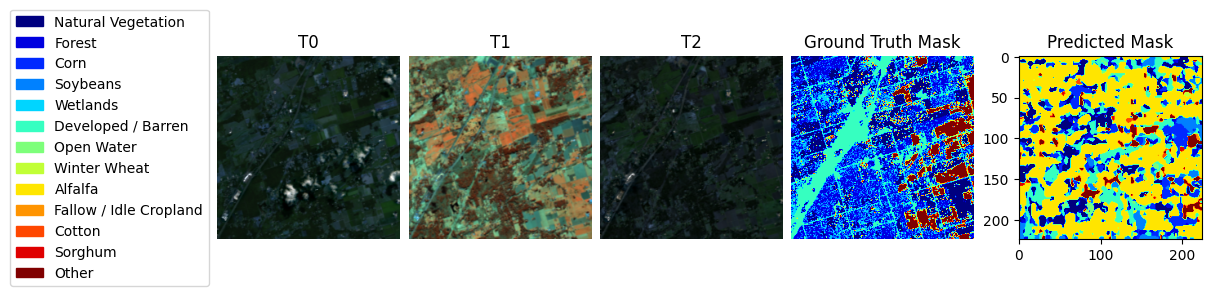

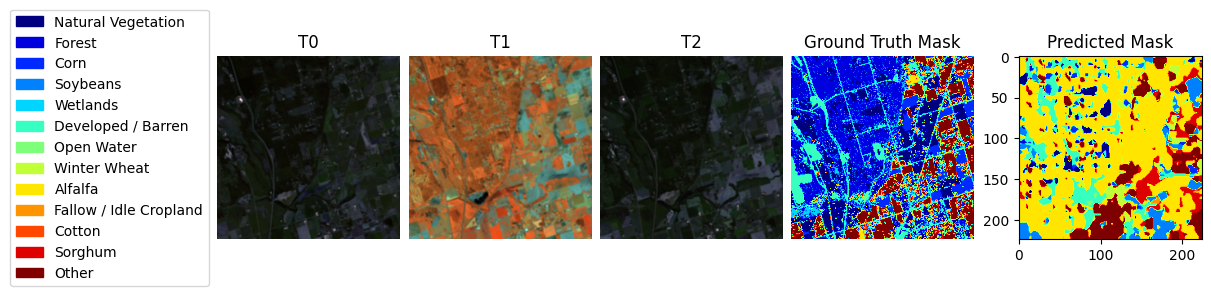

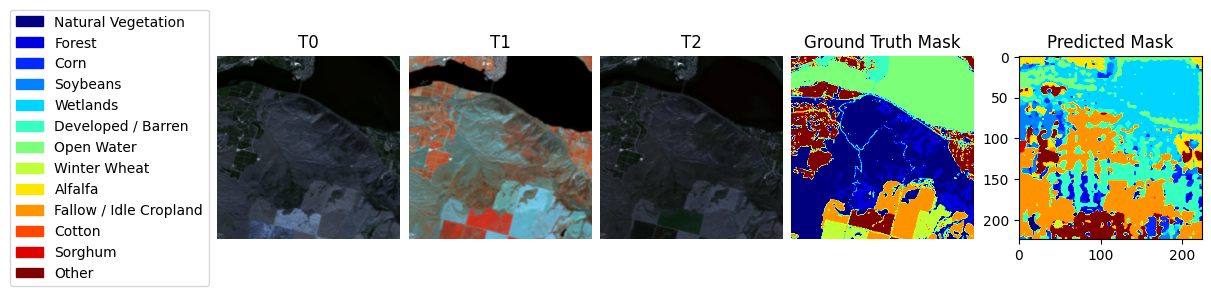

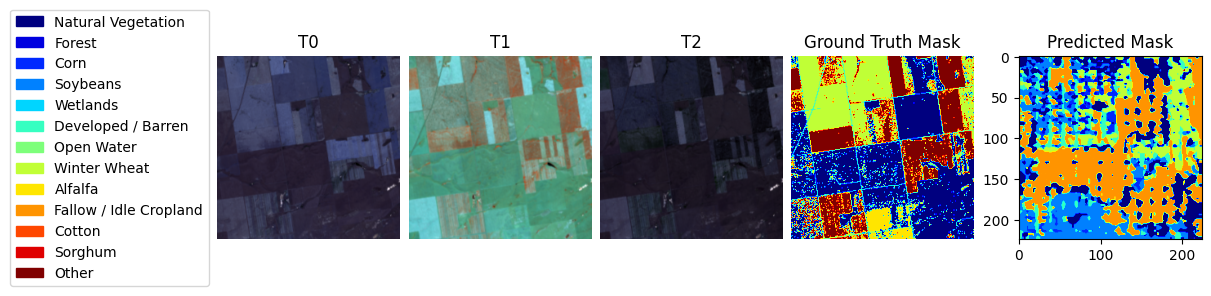

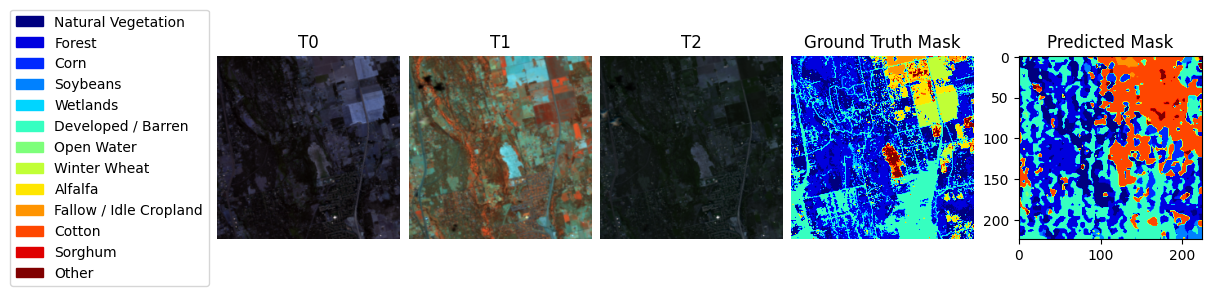

In [17]:
# now we can use the model for predictions and ploting!
best_ckpt_path = checkpoint_callback.best_model_path
model = SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_args=model.hparams.model_args,
    model_factory=model.hparams.model_factory
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].numpy()
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)